<img style="float: left;padding: 1.3em" src="https://indico.in2p3.fr/event/18313/logo-786578160.png">  

#  Gravitational Wave Open Data Workshop #2


#### Tutorial 1.3: Data representations in GWpy

This notebook covers some different ways of representing data, including

- the spectrogram
- the Q-transform
    
[Click this link to view this tutorial in Google Colaboratory](https://colab.research.google.com/github/gw-odw/odw-2019/blob/master/Day_1/Tuto 1.3 Q-transforms with GWpy.ipynb)

##  Installation  (execute only if running on a cloud platform or if you haven't done the installation already!)

Note: we use [`pip`](https://docs.python.org/3.6/installing/), but **it is recommended** to use [conda](https://docs.ligo.org/lscsoft/conda/) on your own machine, as explained in the [installation instructions](https://github.com/gw-odw/odw-2019/blob/master/setup.md). This usage might look a little different than normal, simply because we want to do this directly from the notebook.

In [ ]:
! wget --output-document=requirements.txt 'https://raw.githubusercontent.com/gw-odw/odw-2019/master/requirements.txt'
! pip install -r ./requirements.txt

**Important:** With Google Colab, you may need to restart the runtime after running the cell above.

## Initialization

In [5]:
%matplotlib inline
import gwpy

## Showing the time-evolution of FFTs

The FFT, and the ASD, show us a snapshot of the frequency-domain content of our signal, at a single time.
It is commonly useful to show how this frequency-domain content evolves over time.

For this we use spectrograms, which show the FFT (or ASD) at each time step on a time-frequency-amplitude axis.
The `TimeSeries` in GWpy includes two methods for this:

- [`spectrogram()`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.spectrogram) - show an averaged ASD at each time step, and 
- [`spectrogram2()`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.spectrogram2) - show a single-FFT ASD at each time step

Which one should I use? The short answer is use `spectrogram2()` for short(ish) chunks of data, less than a minute or so, and `spectrogram()` for longer chunks where the averaging helps remove very short noise bursts.

First, let's reload our data:

In [6]:
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries

gps = event_gps('GW170817')
print("GW170817 GPS:", gps)

ldata = TimeSeries.fetch_open_data('L1', int(gps)-512, int(gps)+512, cache=True)
print("GW170817 data")
print(data)

GW170817 GPS: 1187008882.4
GW170817 data
TimeSeries([2.06056010e-20, 1.59181918e-20, 2.18438811e-20, ...,
            1.25504332e-19, 1.23976846e-19, 1.22231459e-19]
           unit: dimensionless,
           t0: 1187008370.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


Now, we can generate our spectrogram using a specific FFT length (remembering to use a window):

<div class="alert alert-info">
Each of these methods returns the output as stacked power spectral densities, so we take the square root to get back to a familiar amplitude spectral density
</div>

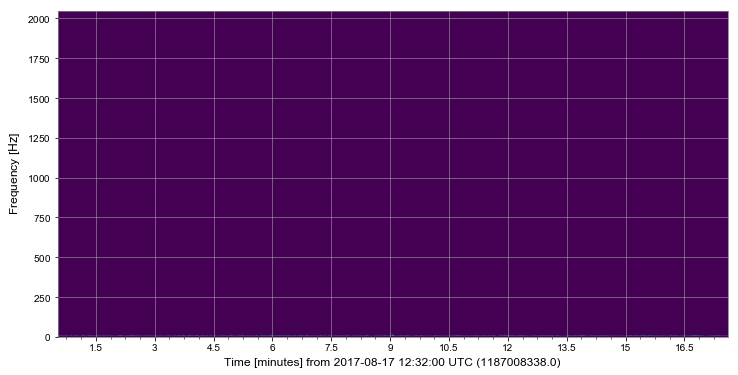

In [18]:
specgram = ldata.spectrogram2(fftlength=4, overlap=2, window='hann') ** (1/2.)
plot = specgram.plot()

Hmmm... something's not right. We need to pass a few more arguments to our plot to control the display (especially the colouring):

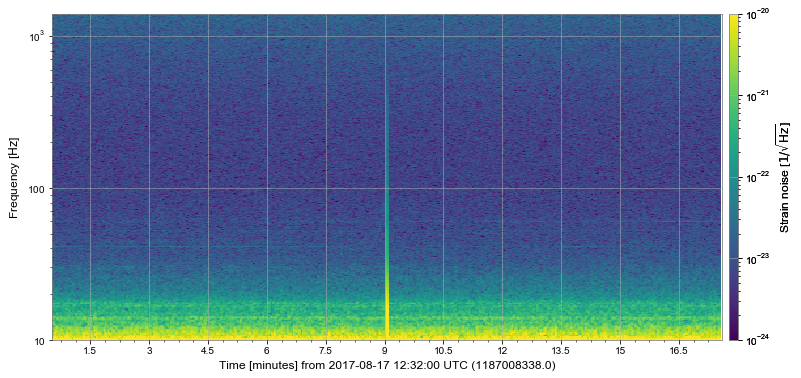

In [20]:
ax = plot.gca()
ax.set_yscale('log')
ax.set_ylim(10, 1400)
ax.colorbar(
    clim=(1e-24, 1e-20),
    norm="log",
    label=r"Strain noise [$1/\sqrt{\mathrm{Hz}}$]",
)
plot  # refresh

Here we can see how the ASD for LIGO-Livingston evolves over a ~17 minute span around GW170817. We can see that the low-frequency noise (<30 Hz) rumbles along with some variation, but high frequencies (>100 Hz) are relatively stable. Between 30-100 Hz we can see some narrow features appearing and disappearing as non-stationary noise affects the measurement.

## Challenge time!

- download the data for all three detectors involved with the GW170814 detection, generate a PSD for each, and make a plot
- make a spectrogram of data for 10 minutes around the GW170817 detection for the LIGO-Livingston detector

## Q-transforms in GWpy

The spectrogram above is a useful way to show the variation of a power spectral density (PSD) estimate over time. It's best used to see general trends in how the sensitivity of the GW detectors is changing over longish periods (minutes or hours).

In this section, we will see how we can use a special filter called a Q-transform to create a time-frequency representation of our data that allows use to pick out features at different frequencies, and how they evolve over very short times, without much prior knowledge of the signal morphology.

See [this article](https://doi.org/10.1088/0264-9381/21/20/024) for more details on the Q-transform and its application to gravitational-wave data.

First, lets reload some data from LIGO Hanford around GW170817:

In [21]:
segment = (int(gps) - 30, int(gps) + 2)
hdata = TimeSeries.fetch_open_data('H1', *segment, verbose=True, cache=True)

Fetched 1 URLs from www.gw-osc.org for [1187008852 .. 1187008884))
Reading data... [Done]


We can now use the `q_transform()` method of the `hdata` `TimeSeries` to create our time-frequency representation (as a [spectrogram](https://gwpy.github.io/docs/stable/spectrogram/)).

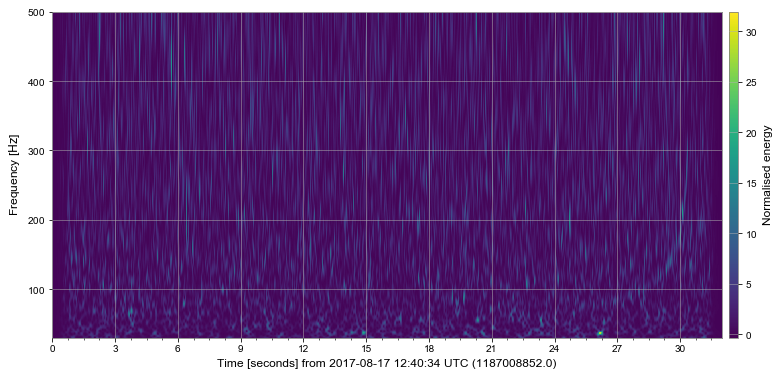

In [26]:
hq = hdata.q_transform(frange=(30, 500))
plot = hq.plot()
plot.colorbar(label="Normalised energy")

From this we can see a different representation of the data. Because the Q-transform returns (by default) normalised energy, the low-frequency rumbling is now much less obvious, and we can see better some noises at higher frequencies.

But, we can clean up the display to better visualise the data:

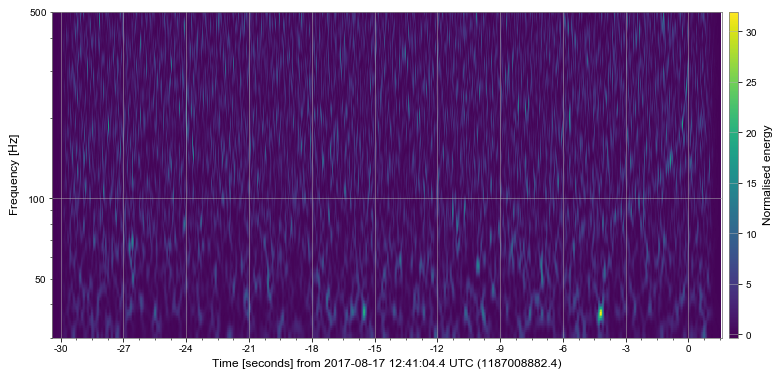

In [28]:
ax = plot.gca()
ax.set_epoch(gps)
ax.set_ylim(30, 500)
ax.set_yscale("log")
plot  # refresh

Now we can see a more prominent feature starting at ~-6 seconds that looks a little familiar.
Here we can use our knowledge of the Q-transform, and our hunch about the origin of the 'feature' to choose a more specific range of 'Q' for the Q-transform, so as to better resolve the feature:

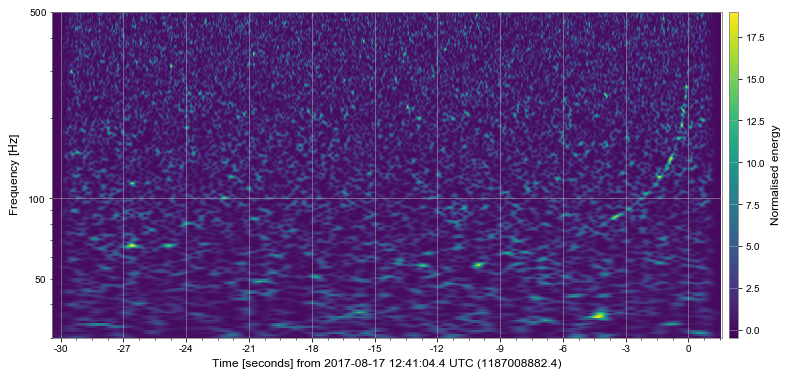

In [29]:
hq = hdata.q_transform(frange=(30, 500), qrange=(100, 110))
plot = hq.plot()
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

Now we see the beautiful, clear track of a BNS merger, visible from about -4 seconds (maye -10 if you squint), all the way through to the merger at T=0.

We can repeat the exercise using LIGO-Livingston data to see something even more remarkable.
First we download and filter the Livingston data:

In [30]:
ldata = TimeSeries.fetch_open_data('L1', *segment, verbose=True)

Fetched 1 URLs from www.gw-osc.org for [1187008852 .. 1187008884))
Reading data... [Done]


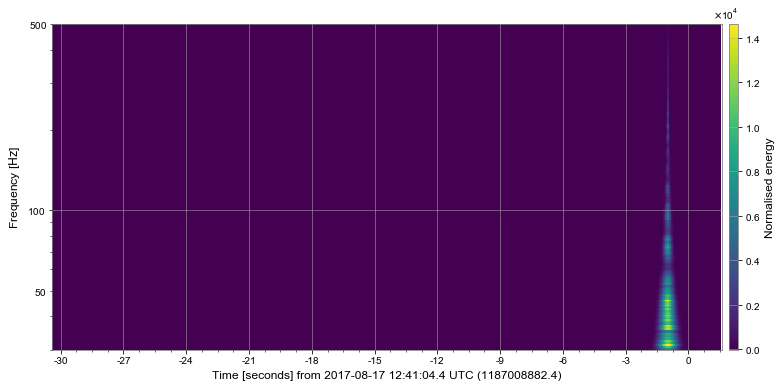

In [32]:
lq = ldata.q_transform(frange=(30, 500), qrange=(100, 110))
plot = lq.plot()
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

Now we can see a large blob of energy that is 1000 times louder than what we see in the LIGO-Hanford data.
As luck would have it, an instrumental glitch almost exactly overlaps the BNS signal in LIGO-Livingston.
But, we can rescale things to see the astrophyscal signal better:

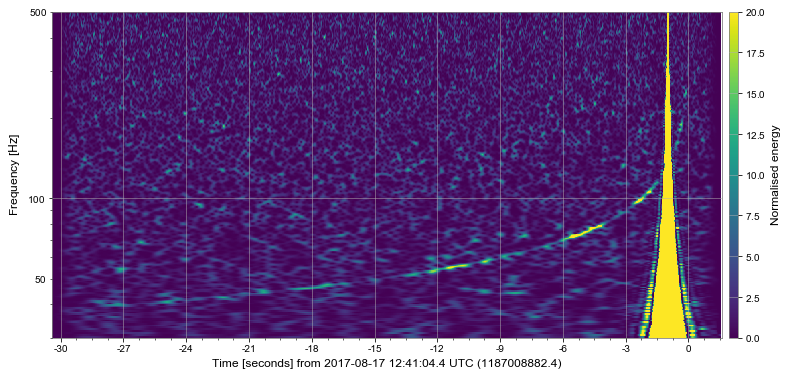

In [33]:
plot.colorbars[0].set_clim(0, 20)
plot.refresh()
plot

Now we can a BNS merger all the way back to T=-25 seconds in LIGO-Livingston data!
 
This is basically the same procedure (and the same code) that was used to produce Figures 1 and 2 of the BNS discovery article '_Observation of Gravitational Waves from a Binary Neutron Star Inspiral_' [[link](https://doi.org/10.1103/PhysRevLett.119.161101)]